### Importing Modules

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque, namedtuple

import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

### Defining of environment

In [3]:
env = gym.make("Taxi-v3")
env_action_space = env.action_space.n
env_state = env.reset()
action = env.action_space.sample()
a, b, c, d = env.decode(env_state)
next_state, reward, done, info = env.step(action)
all_destinations = env.unwrapped.locs
print(f"Initial state : {env_state}")
print(f"Decoded information of initial state => x coordinate of taxi : {a}, y coordinate of taxi : {b}, Passenger location : {c}, Destination : {d}")
print(f"Dictionary : {0} = {all_destinations[0]}, {1} = {all_destinations[1]}, {2} = {all_destinations[2]}, {3} = {all_destinations[3]}, {4} = In taxi")

Initial state : 174
Decoded information of initial state => x coordinate of taxi : 1, y coordinate of taxi : 3, Passenger location : 3, Destination : 2
Dictionary : 0 = (0, 0), 1 = (0, 4), 2 = (4, 0), 3 = (4, 3), 4 = In taxi


### Defining of Epsilon greedy policy for the main Q values and for the option specific Q values

In [4]:
def epsilon_greedy(q_values, state, epsilon):
  if random.uniform(0, 1) > epsilon:
    return np.argmax(q_values[state])
  else:
    return random.randint(0, 9)

def option_epsilon_greedy(q_values, state, epsilon):
    if random.uniform(0, 1) > epsilon:
      state_x, state_y, _, _ = env.decode(state)
      return np.argmax(q_values[state_x][state_y][:6])
    else:
      return random.randint(0, 5)

### Defining of SMDP function

In [5]:
def SMDP(q_values_SMDP, update_frequency_SMDP, options_q_values, alpha = 0.1, epsilon = 0.01):
  gamma = 0.9                                                                    # Gamma is a Fixed parameter
  scores = []                                                                    # For storing Episodic rewards
  for _ in tqdm(range(10000)):                                                   # Ran for 10000 episodes
    state = env.reset()
    done = False
    ep_reward = 0
    while not done:
      action = epsilon_greedy(q_values_SMDP, state, epsilon)
      if action < 6:                                                             # Updation when primitive actions are chosen
        next_state, reward, done, _ = env.step(action)
        q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
        update_frequency_SMDP[state][action] += 1
        ep_reward += reward
        state = next_state
      else:                                                                      # Updation when options where chosen
        if action == 6:                                                          # Option for making the taxi to move to Red location
          destination = env.unwrapped.locs[0]
          q = options_q_values[6]
        elif action == 7:                                                        # Option for making the taxi to move to Green location
          destination = env.unwrapped.locs[1]
          q = options_q_values[7]
        elif action == 8:                                                        # Option for making the taxi to move to Yellow location
          destination = env.unwrapped.locs[2]
          q = options_q_values[8]
        else:                                                                    # Option for making the taxi to move to Blue location
          destination = env.unwrapped.locs[3]
          q = options_q_values[9]
        init_state = state                                                       # Storing the start state of the option for updating later
        rewards = []                                                             # Storing option specific rewards
        while True:
          opt_action = option_epsilon_greedy(q, state, epsilon)
          next_state, reward, done, _ = env.step(opt_action)
          state_x, state_y, _, _ = env.decode(state)
          next_state_x, next_state_y, _, _ = env.decode(next_state)
          rewards.append(reward)
                                                                                 # Updating the option specific q values
          q[state_x][state_y][opt_action] += alpha * (reward + gamma * np.max(q[next_state_x][next_state_y]) - q[state_x][state_y][opt_action])

          state = next_state
          x_taxi, y_taxi, passenger_loc, dest = env.decode(state)
          if x_taxi == destination[0] and y_taxi == destination[1]:              # Checking if the taxi has finished the execution of the option or not
            break
        R = 0
        for reward in rewards[::-1]:                                             # Calculating the return for the option
          R = reward + gamma * R
        ep_reward += R
                                                                                 # Updating the SMDP q value for the option
        q_values_SMDP[init_state][action] += alpha * (R + (gamma ** len(rewards)) * np.max(q_values_SMDP[state]) - q_values_SMDP[init_state][action])
        update_frequency_SMDP[init_state][action] += 1
    scores.append(ep_reward)
  return scores

In [6]:
q_values_SMDP = np.zeros((500, 10))
update_frequency_SMDP = np.zeros((500, 10))
options_q_values = {6 : np.zeros((5, 5, 6)), 7 : np.zeros((5, 5, 6)), 8 : np.zeros((5, 5, 6)), 9 : np.zeros((5, 5, 6))}

scores = SMDP(q_values_SMDP, update_frequency_SMDP, options_q_values)

100%|██████████| 10000/10000 [00:20<00:00, 498.52it/s]


### Reward curve for one run

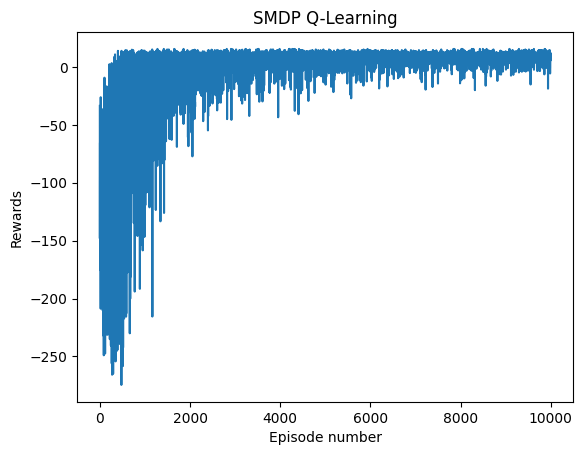

In [7]:
episodes = [i for i in range(len(scores))]
plt.title("SMDP Q-Learning")
plt.xlabel("Episode number")
plt.ylabel("Rewards")
plt.plot(episodes, scores)

### For the Visualization of Q values

In [8]:
q_dict = {}
policy_dict = {}
for pas_loc in np.arange(0, 5):
  for des_loc in np.arange(0, 4):
    q_dict[(pas_loc, des_loc)] = np.zeros((5, 5))
    policy_dict[(pas_loc, des_loc)] = np.zeros((5, 5))

for i in tqdm(range(len(q_values_SMDP))):
  taxi_x, taxi_y, pas_loc, des_loc = env.decode(i)
  q_dict[(pas_loc, des_loc)][taxi_x][taxi_y] = max(q_values_SMDP[i])
  policy_dict[(pas_loc, des_loc)][taxi_x][taxi_y] = np.argmax(q_values_SMDP[i])

100%|██████████| 500/500 [00:00<00:00, 33857.80it/s]


In [9]:
import seaborn

In [10]:
def plot(q_dict, policy_dict):
  fig, axes = plt.subplots(5, 4, figsize = (96, 120))
  for pas_loc in np.arange(0, 5):
    for des_loc in np.arange(0, 4):
      ax = seaborn.heatmap(q_dict[(pas_loc, des_loc)], ax = axes[pas_loc, des_loc])
      if pas_loc != 4:
        axes[pas_loc, des_loc].set_title(f'Passenger location is : {env.unwrapped.locs[pas_loc]} and destination location is : {env.unwrapped.locs[des_loc]}', fontsize = 40)
      else:
        axes[pas_loc, des_loc].set_title(f'Passenger location is : In taxi and destination location is : {env.unwrapped.locs[des_loc]}', fontsize = 40)
      policy = policy_dict[(pas_loc, des_loc)]
      for j in range(policy.shape[0]):
        for k in range(policy.shape[1]):
          action = int(policy[j, k])
          if action == 0:  # Down
            axes[pas_loc, des_loc].arrow(k + 0.5, j + 0.2, 0, 0.4, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')
          elif action == 1:  # Up
            axes[pas_loc, des_loc].arrow(k + 0.5, j + 0.8, 0, - 0.4, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')
          elif action == 2:  # Right
            axes[pas_loc, des_loc].arrow(k + 0.2, j + 0.5, 0.4, 0, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')
          elif action == 3:  # Left
            axes[pas_loc, des_loc].arrow(k + 0.8, j + 0.5, - 0.4, 0, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')
          elif action == 4:  # Pick up
            axes[pas_loc, des_loc].add_patch(plt.Circle((k + 0.5, j + 0.5), 0.1, color = 'aqua'))
          elif action == 5:  # Drop
            axes[pas_loc, des_loc].add_patch(plt.Circle((k + 0.5, j + 0.5), 0.1, color = 'pink'))
          elif action == 6:  # Option 1 of going to (0, 0)
            axes[pas_loc, des_loc].add_patch(plt.Circle((k + 0.5, j + 0.5), 0.1, color = 'red'))
          elif action == 7:  # Option 2 of going to (0, 4)
            axes[pas_loc, des_loc].add_patch(plt.Circle((k + 0.5, j + 0.5), 0.1, color = 'green'))
          elif action == 8:  # Option 3 of going to (4, 0)
            axes[pas_loc, des_loc].add_patch(plt.Circle((k + 0.5, j + 0.5), 0.1, color = 'yellow'))
          elif action == 9:  # Option 4 of going to (4, 3)
            axes[pas_loc, des_loc].add_patch(plt.Circle((k + 0.5, j + 0.5), 0.1, color = 'blue'))
      cbar = ax.collections[0].colorbar
      cbar.ax.tick_params(labelsize = 40)
  plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
plot(q_dict, policy_dict)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


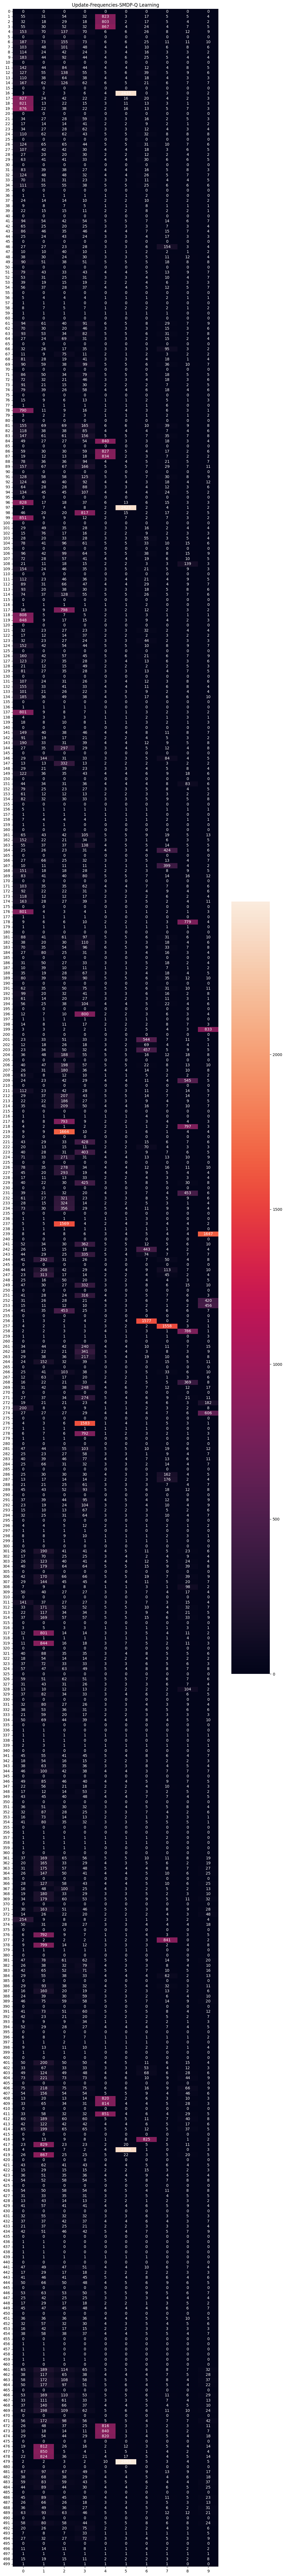

In [12]:
plt.figure(figsize = (12, 120))
seaborn.heatmap(update_frequency_SMDP)
plt.title("Update-Frequencies-SMDP-Q Learning")
for i in range(len(update_frequency_SMDP)):
  for j in range(len(update_frequency_SMDP[i])):
    plt.text(j + 0.5, i + 0.5, f"{update_frequency_SMDP[i][j]:.0f}", ha = 'center', va = 'center', color = 'white')
plt.show()

### Running of one episode

In [13]:
epsilon = 0.01
alpha = 0.1
gamma = 0.9
state = env.reset()
done = False
ep_reward = 0
while not done:
  action = epsilon_greedy(q_values_SMDP, state, epsilon)
  if action < 6:
    next_state, reward, done, _ = env.step(action)
    ep_reward += reward
    a, b, c, d = env.decode(state)
    print(f"Decoded information of current state => x coordinate of taxi : {a}, y coordinate of taxi : {b}, Passenger location : {c}, Destination : {d}")
    state = next_state
  else:
    if action == 6:
      destination = env.unwrapped.locs[0]
      q = options_q_values[6]
    elif action == 7:
      destination = env.unwrapped.locs[1]
      q = options_q_values[7]
    elif action == 8:
      destination = env.unwrapped.locs[2]
      q = options_q_values[8]
    else:
      destination = env.unwrapped.locs[3]
      q = options_q_values[9]
    while True:
      opt_action = option_epsilon_greedy(q, state, epsilon)
      next_state, reward, done, _ = env.step(opt_action)
      a, b, c, d = env.decode(state)
      print(f"Decoded information of current state => x coordinate of taxi : {a}, y coordinate of taxi : {b}, Passenger location : {c}, Destination : {d}")
      state = next_state
      x_taxi, y_taxi, passenger_loc, dest = env.decode(state)
      if x_taxi == destination[0] and y_taxi == destination[1]:
        print(f"Current option ended at : {[x_taxi, y_taxi], destination}")
        break
  a, b, c, d = env.decode(state)
  print(f"Decoded information of current state => x coordinate of taxi : {a}, y coordinate of taxi : {b}, Passenger location : {c}, Destination : {d}")

Decoded information of current state => x coordinate of taxi : 3, y coordinate of taxi : 1, Passenger location : 3, Destination : 0
Decoded information of current state => x coordinate of taxi : 2, y coordinate of taxi : 1, Passenger location : 3, Destination : 0
Decoded information of current state => x coordinate of taxi : 2, y coordinate of taxi : 1, Passenger location : 3, Destination : 0
Decoded information of current state => x coordinate of taxi : 2, y coordinate of taxi : 2, Passenger location : 3, Destination : 0
Decoded information of current state => x coordinate of taxi : 2, y coordinate of taxi : 2, Passenger location : 3, Destination : 0
Decoded information of current state => x coordinate of taxi : 2, y coordinate of taxi : 3, Passenger location : 3, Destination : 0
Decoded information of current state => x coordinate of taxi : 3, y coordinate of taxi : 3, Passenger location : 3, Destination : 0
Current option ended at : ([4, 3], (4, 3))
Decoded information of current st

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From the above run it can be seen that, the agent has been successfully trained